<a href="https://colab.research.google.com/github/Javorai/Coding-Dojo-Core/blob/main/SVM_Challenge_T%C3%A9cnico_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Challenge Técnico (Core)**
**Objetivo:** Los estudiantes deberán participar en una competencia de Kaggle, realizar un análisis completo del dataset, entrenar y evaluar al menos cinco modelos diferentes, y realizar un benchmark para comparar su rendimiento. El resultado final debe ser subido a GitHub.

**Pasos del Challenge:**

 1. **Registro en Kaggle y Elección de Competencia:**

Los estudiantes deben registrarse en Kaggle si no lo han hecho aún.
Elegir una competencia activa que esté alineada con los conocimientos y técnicas aprendidas (por ejemplo, una competencia de clasificación o regresión).


 2. **Carga y Exploración Inicial de Datos:**

* Descargar el [dataset de la competencia](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).
Realizar una exploración inicial para entender la estructura del dataset y las características disponibles.
* Identificar y documentar valores faltantes y outliers.


 3. **Análisis Exploratorio de Datos (EDA):**

* Calcular estadísticas descriptivas básicas.
* Crear visualizaciones para entender la distribución de las variables y sus relaciones.
* Detectar y tratar valores faltantes y outliers.


 4. **Preprocesamiento de Datos:**

* Transformar las columnas según sea necesario (codificación de variables categóricas, escalado de características numéricas).
* Dividir el dataset en conjuntos de entrenamiento y prueba.


 5. **Implementación de Modelos y Benchmark:**

* Entrenar y evaluar al menos cinco modelos diferentes, como Regresión Logística, K-Nearest Neighbors (KNN), Árbol de Decisión, XGBoost y LightGBM.
* Utilizar validación cruzada para evaluar el rendimiento inicial de los modelos.
* Optimizar los hiperparámetros de los modelos seleccionados utilizando GridSearchCV o RandomizedSearchCV.
* Comparar el rendimiento de los modelos utilizando métricas adecuadas.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Descripción General del Conjunto de Datos de Entrenamiento:
--------------------------------------------------
Total de Filas: 1460
Total de Columnas: 81

Valores Faltantes:
              Total  Porcentaje
LotFrontage     259   17.739726
Alley          1369   93.767123
MasVnrType      872   59.726027
MasVnrArea        8    0.547945
BsmtQual         37    2.534247
BsmtCond         37    2.534247
BsmtExposure     38    2.602740
BsmtFinType1     37    2.534247
BsmtFinType2     38    2.602740
Electrical        1    0.068493
FireplaceQu     690   47.260274
GarageType       81    5.547945
GarageYrBlt      81    5.547945
GarageFinish     81    5.547945
GarageQual       81    5.547945
GarageCond       81    5.547945
PoolQC         1453   99.520548
Fence          1179   80.753425
MiscFeature    1406   96.301370

Estadísticas Descriptivas:
                Id   MSSubCla

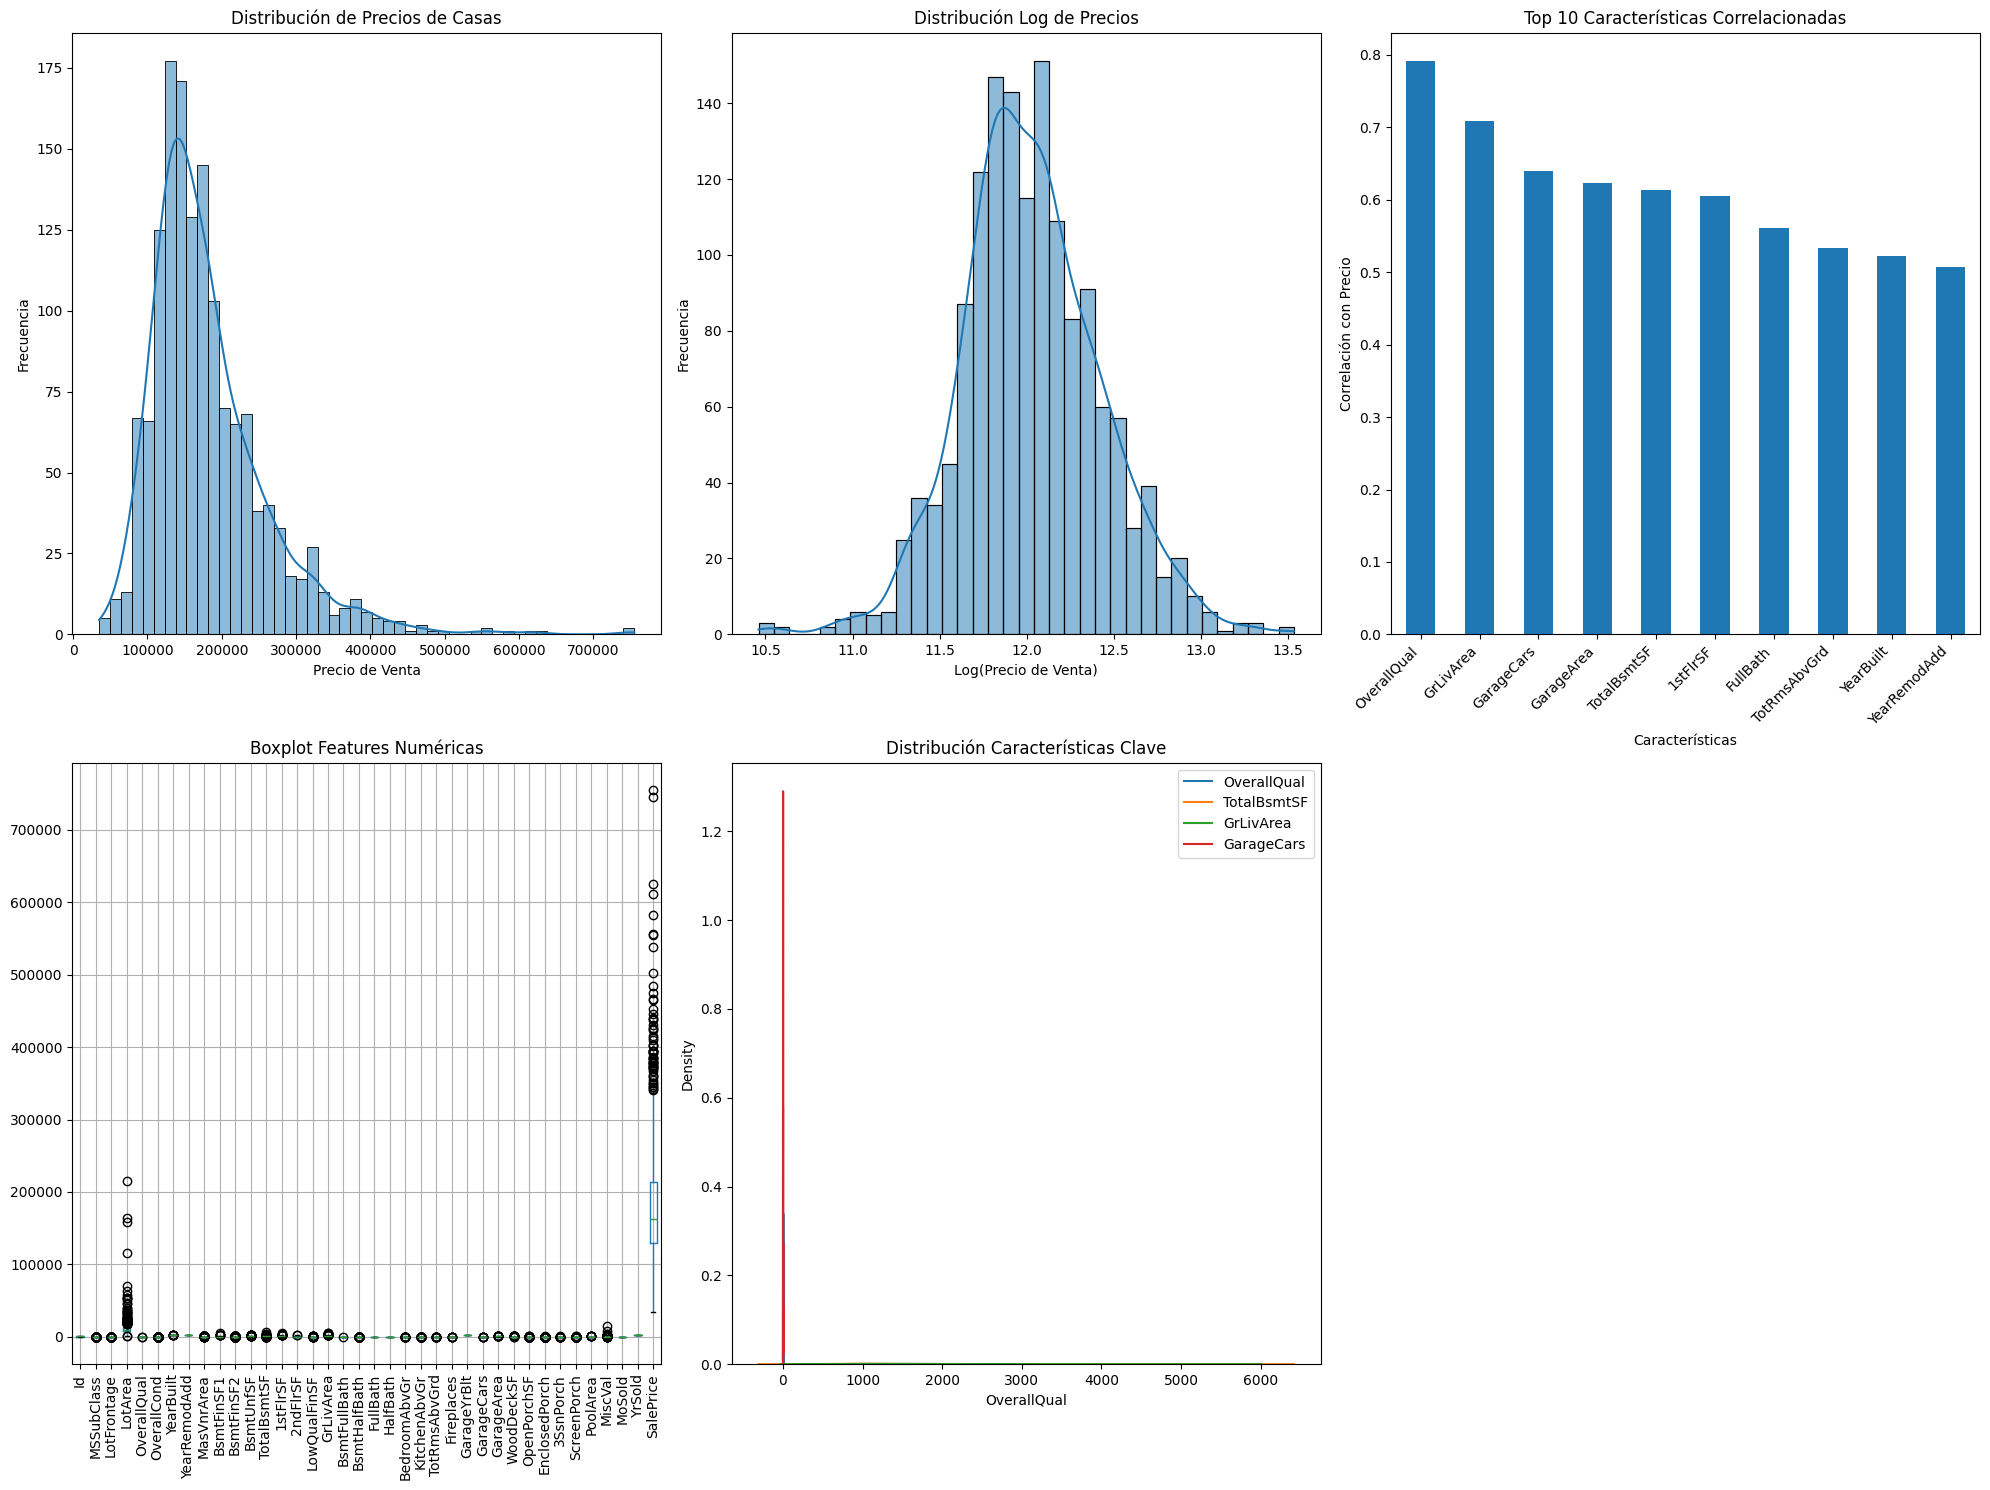

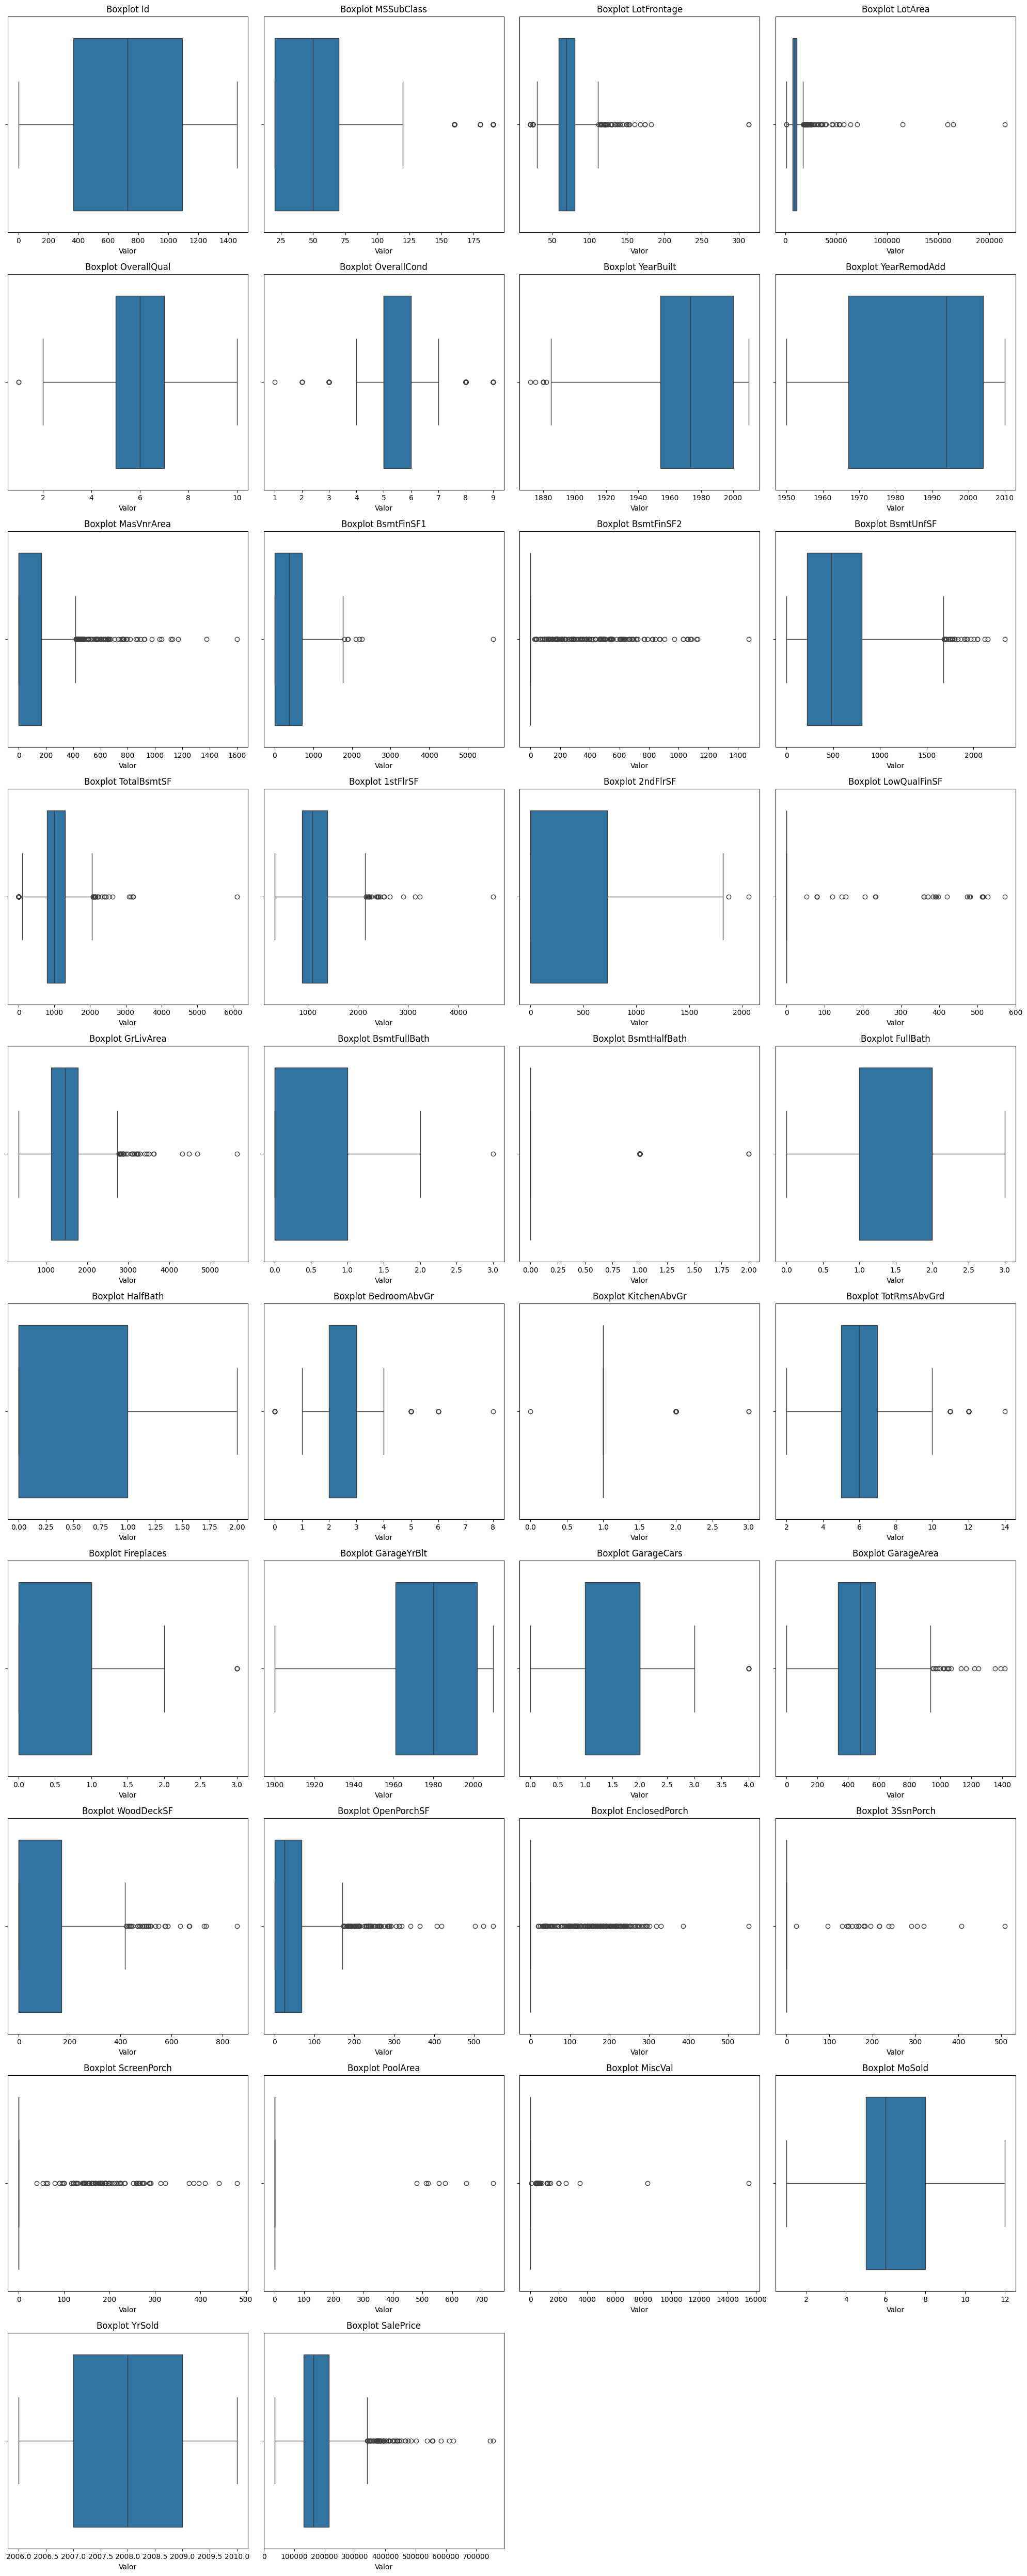

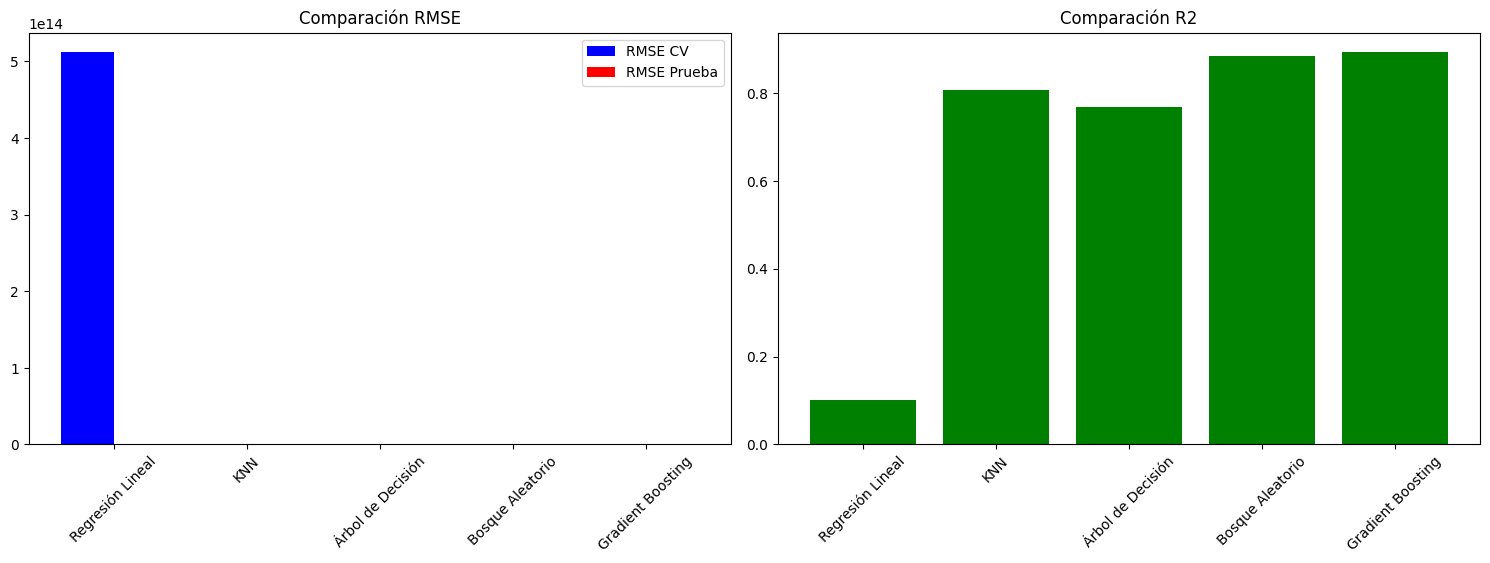

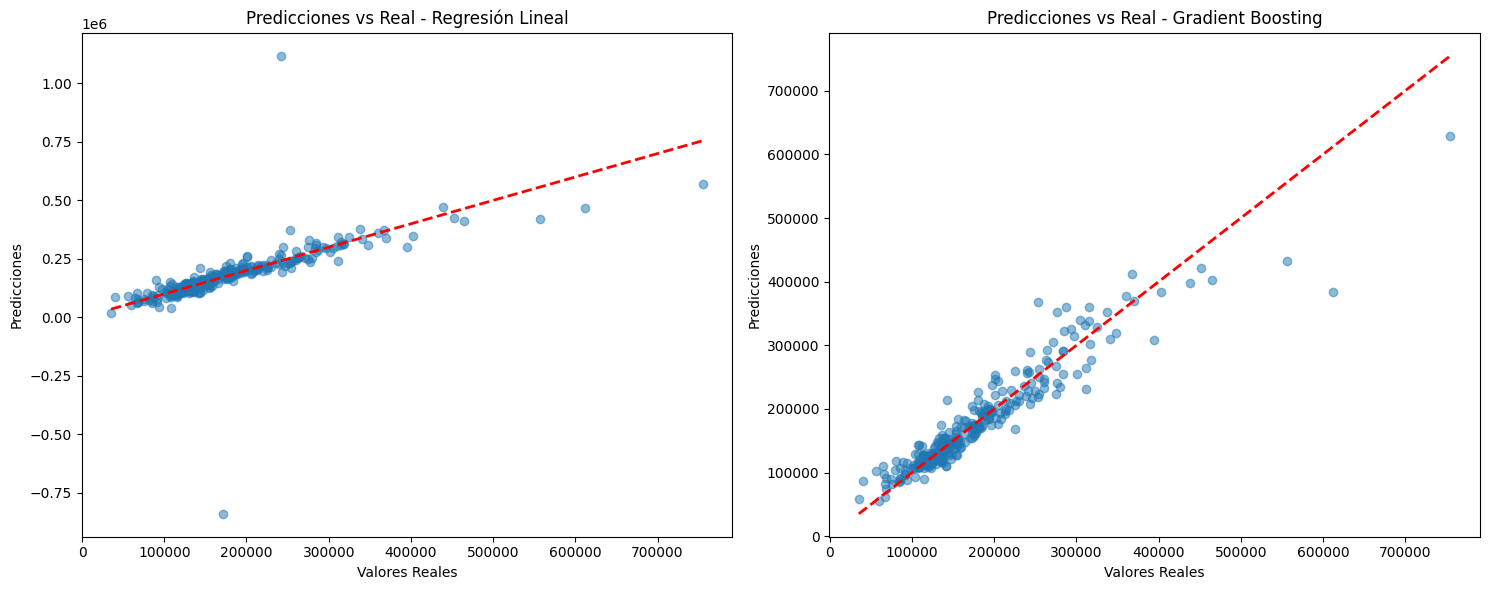

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

# Rutas específicas de Google Drive
RUTA_TRAIN = '/content/drive/MyDrive/Bootcamp Coding Dojo/DataScience/Tareas Core/Archivos CSV-Tareas/SVM   Challenge Técnico (Core)/train.csv'
RUTA_TEST = '/content/drive/MyDrive/Bootcamp Coding Dojo/DataScience/Tareas Core/Archivos CSV-Tareas/SVM   Challenge Técnico (Core)/test.csv'

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

class AnalisisPreciosCasas:
    def __init__(self, ruta_train=RUTA_TRAIN, ruta_test=RUTA_TEST):
        self.datos_entrenamiento = pd.read_csv(ruta_train)
        self.datos_prueba = pd.read_csv(ruta_test)
        self.variable_objetivo = 'SalePrice'

    def exploracion_inicial(self):
        """
        Realizar exploración inicial de datos y documentación
        """
        print("Descripción General del Conjunto de Datos de Entrenamiento:")
        print("-" * 50)
        print(f"Total de Filas: {self.datos_entrenamiento.shape[0]}")
        print(f"Total de Columnas: {self.datos_entrenamiento.shape[1]}")

        # Análisis de Valores Faltantes
        print("\nValores Faltantes:")
        datos_faltantes = self.datos_entrenamiento.isnull().sum()
        porcentajes_faltantes = 100 * datos_faltantes / len(self.datos_entrenamiento)
        resumen_faltantes = pd.concat([datos_faltantes, porcentajes_faltantes], axis=1, keys=['Total', 'Porcentaje'])
        print(resumen_faltantes[resumen_faltantes['Total'] > 0])

    def estadisticas_descriptivas(self):
        """
        Calcular y mostrar estadísticas descriptivas
        """
        columnas_numericas = self.datos_entrenamiento.select_dtypes(include=[np.number]).columns
        estadisticas_descriptivas = self.datos_entrenamiento[columnas_numericas].describe()
        print("\nEstadísticas Descriptivas:")
        print(estadisticas_descriptivas)

    def visualizaciones_descriptivas(self):
        """
        Crear múltiples visualizaciones descriptivas
        """
        plt.figure(figsize=(20, 15))

        # 1. Distribución de SalePrice
        plt.subplot(2, 3, 1)
        sns.histplot(self.datos_entrenamiento[self.variable_objetivo], kde=True)
        plt.title('Distribución de Precios de Casas')
        plt.xlabel('Precio de Venta')
        plt.ylabel('Frecuencia')

        # 2. Log de SalePrice
        plt.subplot(2, 3, 2)
        sns.histplot(np.log(self.datos_entrenamiento[self.variable_objetivo]), kde=True)
        plt.title('Distribución Log de Precios')
        plt.xlabel('Log(Precio de Venta)')
        plt.ylabel('Frecuencia')

        # 3. Top 10 características correlacionadas
        numeric_data = self.datos_entrenamiento.select_dtypes(include=np.number)
        correlaciones = numeric_data.corr()[self.variable_objetivo].sort_values(ascending=False)
        top_correlaciones = correlaciones[1:11]

        plt.subplot(2, 3, 3)
        top_correlaciones.plot(kind='bar')
        plt.title('Top 10 Características Correlacionadas')
        plt.xlabel('Características')
        plt.ylabel('Correlación con Precio')
        plt.xticks(rotation=45, ha='right')

        # 4. Boxplot de características numéricas
        plt.subplot(2, 3, 4)
        numeric_cols = self.datos_entrenamiento.select_dtypes(include=['int64', 'float64']).columns
        self.datos_entrenamiento[numeric_cols].boxplot()
        plt.title('Boxplot Features Numéricas')
        plt.xticks(rotation=90)

        # 5. Distribución de características importantes
        importantes = ['OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageCars']
        plt.subplot(2, 3, 5)
        for col in importantes:
            sns.kdeplot(self.datos_entrenamiento[col], label=col)
        plt.title('Distribución Características Clave')
        plt.legend()

        plt.tight_layout()
        plt.show

    def analisis_outliers(self):
        """
        Análisis detallado de outliers
        """
        numeric_cols = self.datos_entrenamiento.select_dtypes(include=['int64', 'float64']).columns

        num_cols = len(numeric_cols)
        num_rows = (num_cols + 3) // 4

        plt.figure(figsize=(20, 5 * num_rows))

        # Boxplot para identificar outliers en características numéricas
        for i, col in enumerate(numeric_cols, 1):
            plt.subplot(num_rows, 4, i)
            sns.boxplot(x=self.datos_entrenamiento[col])
            plt.title(f'Boxplot {col}')
            plt.xlabel('Valor')

        plt.tight_layout()
        plt.show

    def preparar_datos(self):
        """
        Preprocesar datos para modelos de machine learning
        """
        # Separar características y variable objetivo
        X = self.datos_entrenamiento.drop(self.variable_objetivo, axis=1)
        y = self.datos_entrenamiento[self.variable_objetivo]

        # Identificar columnas numéricas y categóricas
        caracteristicas_numericas = X.select_dtypes(include=['int64', 'float64']).columns
        caracteristicas_categoricas = X.select_dtypes(exclude=['int64', 'float64']).columns

        # Imprimir información sobre las características
        print("Características numéricas:", len(caracteristicas_numericas))
        print("Características categóricas:", len(caracteristicas_categoricas))

        # Crear preprocesadores
        transformador_numerico = Pipeline(steps=[
            ('imputador', SimpleImputer(strategy='median')),
            ('escalador', StandardScaler())
        ])

        transformador_categorico = Pipeline(steps=[
            ('imputador', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
        ])

        # Crear el preprocesador columnar
        preprocesador = ColumnTransformer(
            transformers=[
                ('num', transformador_numerico, caracteristicas_numericas),
                ('cat', transformador_categorico, caracteristicas_categoricas)
            ])

        # Dividir datos
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        return X_train, X_test, y_train, y_test, preprocesador

    def entrenar_y_evaluar_modelos(self, X_train, X_test, y_train, y_test, preprocesador):
        """
        Entrenar y evaluar múltiples modelos de regresión
        """
        modelos = {
            'Regresión Lineal': LinearRegression(),
            'KNN': KNeighborsRegressor(n_neighbors=5),
            'Árbol de Decisión': DecisionTreeRegressor(random_state=42),
            'Bosque Aleatorio': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(random_state=42)
        }

        resultados = {}

        for nombre, modelo in modelos.items():
            try:
                pipeline = Pipeline(steps=[
                    ('preprocesador', preprocesador),
                    ('regresor', modelo)
                ])

                # Validación cruzada
                puntajes_cv = cross_val_score(pipeline, X_train, y_train,
                                            cv=5, scoring='neg_mean_squared_error')
                puntajes_rmse_cv = np.sqrt(-puntajes_cv)

                # Entrenar y predecir
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)

                # Métricas de evaluación
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                resultados[nombre] = {
                    'RMSE de CV': puntajes_rmse_cv.mean(),
                    'RMSE de Prueba': rmse,
                    'MAE': mae,
                    'R2': r2
                }

                print(f"Modelo {nombre} entrenado exitosamente")

            except Exception as e:
                print(f"Error en el modelo {nombre}: {str(e)}")
                continue

        # Mostrar resultados
        if resultados:
            df_resultados = pd.DataFrame.from_dict(resultados, orient='index')
            print("\nComparación de Rendimiento de Modelos:")
            print(df_resultados)
        else:
            print("No se pudieron entrenar los modelos correctamente")

        return resultados

    def comparacion_modelos(self, resultados_modelos):
        """
        Visualización comparativa de rendimiento de modelos
        """
        plt.figure(figsize=(15, 10))

        # Comparación RMSE
        plt.subplot(2, 2, 1)
        rmse_cv = [resultados_modelos[modelo]['RMSE de CV'] for modelo in resultados_modelos]
        rmse_prueba = [resultados_modelos[modelo]['RMSE de Prueba'] for modelo in resultados_modelos]

        x = range(len(resultados_modelos))
        plt.bar([i-0.2 for i in x], rmse_cv, width=0.4, label='RMSE CV', color='blue')
        plt.bar([i+0.2 for i in x], rmse_prueba, width=0.4, label='RMSE Prueba', color='red')
        plt.title('Comparación RMSE')
        plt.xticks(x, list(resultados_modelos.keys()), rotation=45)
        plt.legend()

        # Comparación R2
        plt.subplot(2, 2, 2)
        r2_scores = [resultados_modelos[modelo]['R2'] for modelo in resultados_modelos]
        plt.bar(list(resultados_modelos.keys()), r2_scores, color='green')
        plt.title('Comparación R2')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show

    def predicciones_vs_reales(self, X_train, X_test, y_train, y_test, preprocesador):
        """
        Graficar predicciones vs valores reales para diferentes modelos
        """
        mejores_modelos = {
            'Regresión Lineal': LinearRegression(),
            'Gradient Boosting': GradientBoostingRegressor()
        }

        plt.figure(figsize=(15, 6))

        for i, (nombre, modelo) in enumerate(mejores_modelos.items(), 1):
            pipeline = Pipeline(steps=[
                ('preprocesador', preprocesador),
                ('regresor', modelo)
            ])

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

            plt.subplot(1, 2, i)
            plt.scatter(y_test, y_pred, alpha=0.5)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
            plt.title(f'Predicciones vs Real - {nombre}')
            plt.xlabel('Valores Reales')
            plt.ylabel('Predicciones')

        plt.tight_layout()
        plt.show

def main():
    analisis = AnalisisPreciosCasas()

    # Exploración Inicial
    analisis.exploracion_inicial()

    # Estadísticas Descriptivas
    analisis.estadisticas_descriptivas()

    # Visualizaciones Extendidas
    analisis.visualizaciones_descriptivas()
    analisis.analisis_outliers()

    # Preparar y Modelar Datos
    X_train, X_test, y_train, y_test, preprocesador = analisis.preparar_datos()
    resultados = analisis.entrenar_y_evaluar_modelos(X_train, X_test, y_train, y_test, preprocesador)

    # Visualizaciones Adicionales
    analisis.comparacion_modelos(resultados)
    analisis.predicciones_vs_reales(X_train, X_test, y_train, y_test, preprocesador)

if __name__ == "__main__":
    main()

# **Análisis Detallado de Precios de Viviendas**

Análisis detallado de los precios de las viviendas y sus características relacionadas:

* Distribución de Precios de Casas (Histograma): La mayoría de los precios de las viviendas están entre 100,000 y 300,000.

* Distribución Log de Precios: Transformación logarítmica muestra una distribución más simétrica, similar a una distribución normal.

* Top 10 Características Correlacionadas (Gráfico de Barras): Las características más correlacionadas con los precios son OverallQual, GrLivArea, GarageCars, entre otras.

* Boxplot de Features Numéricas: Muestra la dispersión y los valores atípicos de varias características.

* Distribución Características Clave (Gráfico de Densidad): La distribución de densidad para características clave como OverallQual, TotalBsmtSF, GrLivArea, y GarageCars.

# **Boxplots de Variables**
Los gráficos con boxplots representan diferentes variables en un conjunto de datos relacionado con características de viviendas. Los boxplots permiten visualizar la distribución y los valores atípicos (outliers) de cada una de las variables listadas, como:

* MSSubClass: Clase del edificio.

* LotFrontage: Longitud de la calle conectada a la propiedad.

* OverallQual: Calidad general del material y acabado de la casa.

* YearBuilt: Año de construcción.

Estos gráficos ayudan a entender cómo se distribuyen las características y a identificar cualquier valor extremo que podría influir en el análisis.

# **Gráficos de Barras Comparando Modelos (RMSE y R2)**
Los gráficos de barras comparan diferentes modelos de machine learning en base a las métricas RMSE (Root Mean Square Error) y R2 (Coeficiente de Determinación).

* Comparación RMSE: Indica que la Regresión Lineal tiene el RMSE más alto, sugiriendo un peor ajuste comparado con otros modelos como KNN, Árbol de Decisión, Bosque Aleatorio y Gradient Boosting.

* Comparación R2: Muestra que la Regresión Lineal tiene el valor de R2 más bajo, lo que indica un peor ajuste en comparación con los otros modelos.

# **Scatter Plots de Predicciones vs. Valores Reales**
Los gráficos de dispersión comparan los valores predichos con los valores reales para dos modelos de regresión diferentes:

* Regresión Lineal: Los puntos muestran una dispersión considerable alrededor de la línea ideal, indicando una precisión limitada.

* Gradient Boosting: Los puntos están mejor alineados con la línea ideal, indicando una mayor precisión en las predicciones.

Estos gráficos son útiles para visualizar cómo de bien se ajustan los modelos a los datos.

# **Conclusión**
El conjunto de gráficos proporciona una visión completa y detallada del análisis de un dataset de viviendas, abarcando desde la exploración de datos y visualización de distribuciones, hasta la comparación de modelos de machine learning y su precisión en las predicciones. Los diferentes tipos ofrecen una comprensión profunda de cómo se distribuyen las características y cómo de bien los modelos pueden predecir los precios de las viviendas.